In [ ]:
import requests
from bs4 import BeautifulSoup
import os
import sys
from urllib.parse import urlparse, urljoin
import numpy as np
import pandas as pd
from tqdm.auto import tqdm


pd.set_option("max_columns",100)

DATA_DIR="./Data/OnlineNewsPopularity/"

In [ ]:
news_df=pd.read_csv(DATA_DIR+"OnlineNewsPopularity.csv")
news_df.info()

In [ ]:
news_df.head()

In [ ]:
news_df['url'][:13214].to_csv("first.csv", index_label='ID')
news_df['url'][13214:26428].to_csv("second.csv", index_label='ID')
news_df['url'][26428:].to_csv("third.csv", index_label='ID')

In [ ]:
loop=tqdm(pd.read_csv("second.csv").values[:10])

for ID,url in loop:
    print(ID, url)

## Consistent filenames and url index

In [ ]:
l=[]
l+=[pd.read_csv("first.csv")]
l+=[pd.read_csv("second.csv")]
l+=[pd.read_csv("third.csv")]

files_df=pd.concat(l, ignore_index=True)
files_df['ID']=files_df['ID'].astype(str)+".html"
files_df.head()

In [ ]:
files_df.info()

In [ ]:
files_df.to_csv(DATA_DIR+"files.csv", index=False, header=['file', 'url'])

In [ ]:
files_df=pd.read_csv(DATA_DIR+"files.csv")
files_df['file']=DATA_DIR+"mashable/"+files_df['file']
files_df.head()

# Check all titles

In [ ]:
loop=tqdm(files_df.values)
headlines=[]
for file, url in loop:
    try:
        with open(file,'r') as f:
            soup=BeautifulSoup(f.read(), 'lxml')
            x=soup.find("meta",{"property":"og:title"})
            if x is not None:
                headlines+=[x['content']]
            else:
                headlines+=[None]
                print("No title", url, file)
    except Exception as e:
        print(url, file, e)
        print()

In [2]:
def getMeta(soup, *args):
    l=[]
    for arg in args:
        x=soup.find("meta", arg)
        if x is not None:
            l.append(x['content'])
        else:
            print("No %s"%arg['property'], url, file)
            l.append(None)
    return l

## All meta except body

In [ ]:
from io import StringIO
from csv import writer 
import pandas as pd

loop=tqdm(files_df.values)
output = StringIO()
csv_writer = writer(output)
csv_writer.writerow(["url", "Title", "Keywords", "Description", "Author", "Published"])


for file, url in loop:
    # URL, Title, Keywords, Desc, Author, Publish Time
    row=[url]
    with open(file,'r') as f:
        cont=f.read()
        if cont.find("Access Denied")!=-1 or cont.find("We couldn't find the page you were looking for.")!=-1:
            row+=[None, None, None, None]
        else:    
            soup=BeautifulSoup(cont, 'lxml')
            row+=getMeta(soup, 
                       {"property":"og:title"}, 
                       {"name":"keywords"},
                       {"property":"og:description"},
                       {"name":"sailthru.author"},
                       {"property":"og:article:published_time"})
            
        csv_writer.writerow(row)

output.seek(0)
df = pd.read_csv(output)
df

In [5]:
for i in df:
    print(df[i].isnull().value_counts())

False    39644
Name: url, dtype: int64
False    39606
True        38
Name: Title, dtype: int64
False    39606
True        38
Name: Keywords, dtype: int64
False    39606
True        38
Name: Description, dtype: int64
False    39606
True        38
Name: Author, dtype: int64
False    39606
True        38
Name: Published, dtype: int64


In [21]:
df.to_csv("Articles_meta.csv", index=False)

## Df body content

In [ ]:
import json


from io import StringIO
from csv import writer 
import pandas as pd

loop=tqdm(files_df.values)
output = StringIO()
csv_writer = writer(output)
csv_writer.writerow(["url", "Body"])


for file, url in loop:
    # URL, Title, Keywords, Desc, Author, Publish Time
    row=[url]
    with open(file,'r') as f:
        cont=f.read()
        if cont.find("Access Denied")!=-1 or cont.find("We couldn't find the page you were looking for.")!=-1:
            row+=[None]
        else:    
            soup=BeautifulSoup(cont, 'lxml')
            x=soup.find("script", {"type":"application/ld+json"}).string
            if x is not None:
                row+=[json.loads(x)['articleBody']]
            else:
                print(url, file, "Bad article body")
                row+=None
        csv_writer.writerow(row)

output.seek(0)
df_body = pd.read_csv(output)
df_body

In [43]:
df_body.to_csv("Articles_body.csv", index=False)

## Readability scores

In [7]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm


pd.set_option("max_columns",100)

DATA_DIR="./Data/OnlineNewsPopularity/"

In [8]:
df_body=pd.read_csv("Articles_body.csv")
df_body=df_body.dropna()

In [12]:
from pandarallel import pandarallel
from readability.readability import Readability


pandarallel.initialize()

def get_readability(row):
    rd=Readability(row.Body)
    return row.url,rd.ARI(),rd.FleschReadingEase(),rd.FleschKincaidGradeLevel(),rd.GunningFogIndex(),rd.SMOGIndex(),rd.ColemanLiauIndex(),rd.LIX(),rd.RIX()

scores=df_body.parallel_apply(get_readability, axis=1, result_type='expand')

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [14]:
scores.columns=['url', 
                'ARI', 
                'FleschReadingEase', 
                'FleschKincaidGradeLevel', 
                'GunningFogIndex', 
                'SMOGIndex', 
                'ColemanLiauIndex', 
                'LIX', 
                'RIX']

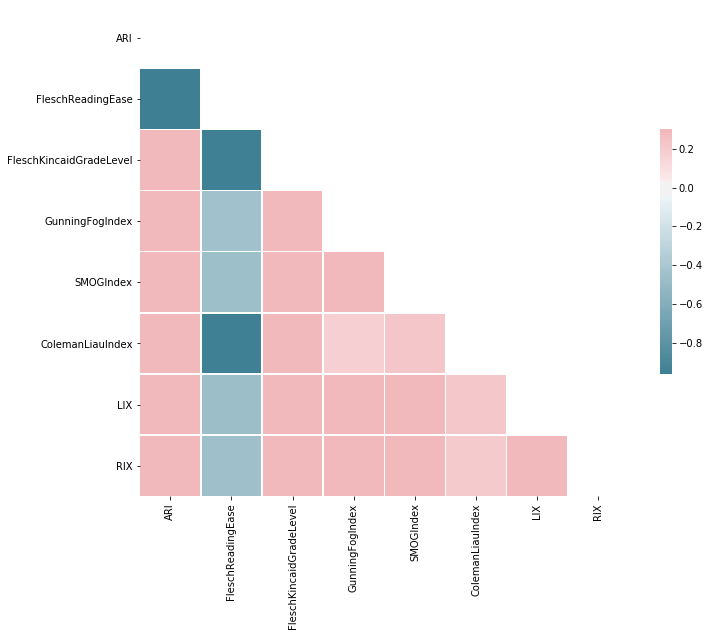

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = scores.iloc[:,1:].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [21]:
scores.to_csv("readability.csv", index=False)